In [1]:
# import library 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm  # Import tqdm for the progress bar
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from skimage import exposure
import sys
from torchvision.utils import make_grid
from skimage.transform import resize
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# # Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#the below parts are to activate GPU support on on ARM Macs however,
#not all torch operations are supprted as of today so we moved to kaggle env

# has_gpu = torch.cuda.is_available()
# has_mps = torch.backends.mps.is_built()
# device = "mps" if torch.backends.mps.is_built() \
#     else "gpu" if torch.cuda.is_available() else "cpu"
# print(f"Python Platform: {platform.platform()}")
# print(f"PyTorch Version: {torch.__version__}")
# print()
# print(f"Python {sys.version}")
# # print(f"Pandas {pd.__version__}")
# # print(f"Scikit-Learn {sk.__version__}")
# print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
# print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
# print(f"Target device is {device}")
# import os
# # Set the environment variable
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:
device

device(type='cuda')

# Data preparation

Class Names: ['dog', 'cat']


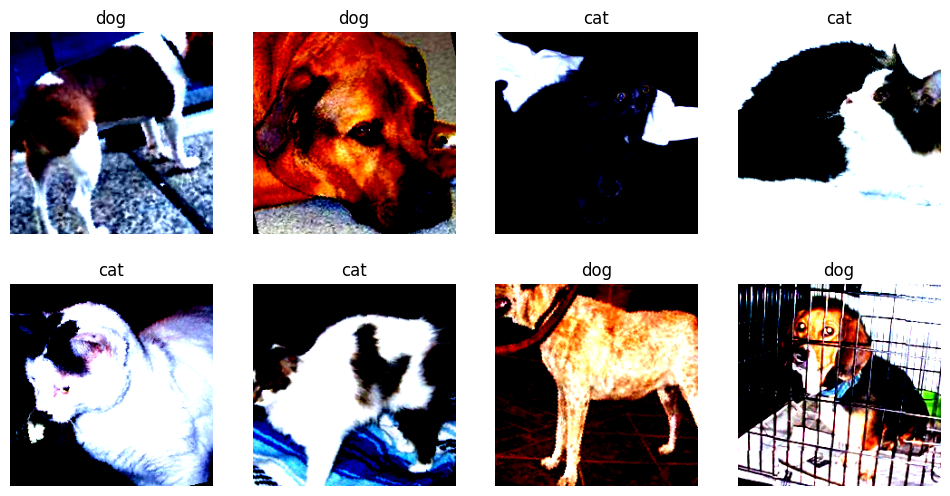

In [4]:
# custom dataset class that can load the image names and labels from path
class CustomDataset(Dataset):
    def __init__(self, data_dir, image_names, transform=None):
        self.data_dir = data_dir
        self.image_names = image_names
        self.transform = transform
        self.unique_labels = self.get_unique_labels()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label = self.get_label(img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_label(self, image_name):
        return image_name.split('.')[0]

    def get_unique_labels(self):
        return list(set([self.get_label(img_name) for img_name in self.image_names]))
    
    
data_dir = '/kaggle/input/dogs-vs-cats/train/train/'

# Get a list of all image filenames in the data directory
all_images = os.listdir(data_dir)
# Split data into train and validation sets
train_image_names, valid_image_names = train_test_split(all_images, test_size=0.1, random_state=42)

# New normalization values these are based on ImageNet.
new_mean = [0.485, 0.456, 0.406]
new_std = [0.229, 0.224, 0.225]

# Transform for training data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(new_mean, new_std)
])
# Transform for validation data
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(new_mean, new_std)
])
# Create training dataset and dataloader
train_dataset = CustomDataset(data_dir, train_image_names, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create validation dataset and dataloader
valid_dataset = CustomDataset(data_dir, valid_image_names, transform=valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.get_unique_labels()
print("Class Names:", class_names)

# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Display 8 images with labels
plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(inputs[i].permute(1, 2, 0))
    plt.title(classes[i])
    plt.axis('off')
plt.show()

# Model training

In [5]:
# custom model based on alexnet and modfied for deconvolution
class CustomDeConvNet(nn.Module):
    def __init__(self, num_classes=None):
        super(CustomDeConvNet, self).__init__()
        # Layer 1
        self.layer1conv = nn.Conv2d(3, 96, kernel_size=7, stride=2)
        self.layer1relu = nn.ReLU()
        self.layer1pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        self.layer1norm = nn.LocalResponseNorm(55)

        # Layer 2
        self.layer2conv = nn.Conv2d(96, 256, kernel_size=5, stride=2)
        self.layer2relu = nn.ReLU()
        self.layer2pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        self.layer2norm = nn.LocalResponseNorm(27)

        # Layer 3
        self.layer3conv = nn.Conv2d(256, 384, kernel_size=3, stride=1,padding=1)
        self.layer3relu = nn.ReLU()

        # Layer 4
        self.layer4conv = nn.Conv2d(384, 384, kernel_size=3, stride=1,padding=1)
        self.layer4relu = nn.ReLU()

        # Layer 5
        self.layer5conv = nn.Conv2d(384, 256, kernel_size=3)
        self.layer5relu = nn.ReLU()
        self.layer5pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        self.layer5norm = nn.LocalResponseNorm(13)

        # Deconvolution and Unpooling Layers
        self.deconv5relu = nn.ReLU()
        self.unpool5 = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv5 = nn.ConvTranspose2d(256, 384, kernel_size=3)
        # self.unpool4 = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv4relu = nn.ReLU()
        self.deconv4 = nn.ConvTranspose2d(384, 384, kernel_size=3, stride=1,padding=1)
        # self.unpool3 = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv3relu = nn.ReLU()
        self.deconv3 = nn.ConvTranspose2d(384, 256, kernel_size=3,stride=1,padding=1)
        self.deconv2relu = nn.ReLU()
        self.unpool2 = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(256, 96, kernel_size=5, stride=2)
        self.deconv1relu = nn.ReLU()
        self.unpool1 = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose2d(96, 3, kernel_size=7, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(4 * 4 * 256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        

    def forward(self, x):
        intermediate_feature_maps = {} # save intermediate layer outputs 

        # Layer 1
        x1conv = self.layer1conv(x)
        x1relu = self.layer1relu(x1conv)
        x1pool, x1poolind = self.layer1pool(x1relu)
        x1norm = self.layer1norm(x1pool)
        intermediate_feature_maps['layer1'] = x1pool
        # print(f' layer 1 conv {x1conv.size()}, pool {x1pool.size()} norm {x1norm.size()}')

        # Layer 2
        x2conv = self.layer2conv(x1norm)
        x2relu = self.layer2relu(x2conv)
        x2pool, x2poolind = self.layer2pool(x2relu)
        x2norm = self.layer2norm(x2pool)
        intermediate_feature_maps['layer2'] = x2pool
        # print(f'layer 2 conv {x2conv.size()}, pool {x2pool.size()} norm {x2norm.size()}')

        # Layer 3
        x3conv = self.layer3conv(x2norm)
        x3relu = self.layer3relu(x3conv)
        intermediate_feature_maps['layer3'] = x3conv
        # print(f'layer 3 conv {x3conv.size()}')

        # Layer 4
        x4conv = self.layer4conv(x3relu)
        x4relu = self.layer4relu(x4conv)
        intermediate_feature_maps['layer4'] = x4conv
        # print(f'layer 4 conv {x4conv.size()}')

        # Layer 5
        x5conv = self.layer5conv(x4relu)
        x5relu = self.layer5relu(x5conv)
        x5pool, x5poolind = self.layer5pool(x5relu)
        x5norm = self.layer5norm(x5pool)
        intermediate_feature_maps['layer5'] = x5pool
        # print(f'layer 5 conv {x5conv.size()}, pool {x5pool.size()} norm {x5norm.size()}')

        # Deconvolution and Unpooling
        x5unpool = self.unpool5(x5norm, x5poolind, output_size=x5relu.size())
        # print(f'unpool5 {x5unpool.size()}')
        deconv5relu = self.deconv5relu(x5unpool)
        x5deconv = self.deconv5(deconv5relu, output_size=x4conv.size())
        intermediate_feature_maps['deconv5'] = x5deconv  # Store deconv5 output
        # print(f'deconv5 {x5deconv.size()}')
        
        deconv4relu = self.deconv4relu(x5deconv)
        x4deconv = self.deconv4(deconv4relu, output_size=x3conv.size())
        intermediate_feature_maps['deconv4'] = x4deconv  # Store deconv4 output
        # print(f'deconv4 {x4deconv.size()}')
        
        deconv3relu = self.deconv3relu(x4deconv)
        x3deconv = self.deconv3(deconv3relu, output_size=x2norm.size())
        intermediate_feature_maps['deconv3'] = x3deconv  # Store deconv3 output
        # print(f'deconv3 {x3deconv.size()}')
        
        x2unpool = self.unpool2(x3deconv, x2poolind, output_size=x2relu.size())
         # print(f'unpool2 {x2unpool.size()}')
        deconv2relu = self.deconv2relu(x2unpool)
        x2deconv = self.deconv2(deconv2relu, output_size=x1norm.size())
        intermediate_feature_maps['deconv2'] = x2deconv  # Store deconv2 output
        
        x1unpool = self.unpool1(x2deconv, x1poolind, output_size=x1relu.size())
        # print(f'unpool1 {x2unpool.size()}')
        deconv1relu = self.deconv1relu(x1unpool)
        x_reconstructed = self.deconv1(deconv1relu, output_size=x.size())
        intermediate_feature_maps['deconv1'] = x_reconstructed  # Store deconv1 output
        # print(f'deconv1 {x_reconstructed.size()}')

        # Flatten the output for fully connected layers
        x_flatten = x5norm.view(x5norm.size(0), -1)
        intermediate_feature_maps['deconv_output'] = x_flatten

        # Fully connected layers
        x = self.fc1(x_flatten)
        x = self.fc2(x)
        x = self.fc3(x)

        return x, intermediate_feature_maps


# Create an instance of the model
model = CustomDeConvNet(num_classes=len(class_names))
# Print the model architecture
# print(model)
# Send the model to the device
model = model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
# # Assuming already defined model, dataloaders, optimizer, criterion, etc.
# # variables for metric calculations
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# num_epochs = 15 
# class_to_idx = {'cat': 0, 'dog': 1}
# for epoch in range(num_epochs):
#     print('epoch: ', epoch + 1)
#     for phase in ['train', 
#                   'valid'
#                   ]:
#         if phase == 'train':
#             model.train()
#         else:
#             model.eval()

#         running_loss = 0.0
#         running_corrects = 0
#         total_samples = 0

#         #tqdm to create a progress bar
#         data_loader = tqdm(train_loader, desc=f'{phase} Epoch {epoch + 1}/{num_epochs}')

#         for (inputs, labels) in data_loader:
#             numerical_labels = [class_to_idx[label] for label in labels]
#             inputs = torch.tensor(inputs, dtype=torch.float32, requires_grad=True)
#             inputs = inputs.to(device)
            
#             labels = torch.tensor(numerical_labels, dtype=torch.long).to(device)

#             optimizer.zero_grad()
#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs,features = model(inputs)
#                 loss = criterion(outputs, labels)

#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             _, preds = torch.max(outputs, 1)

#             # update running loss and correct predictions
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#             total_samples += inputs.size(0)

#         # calculate epoch loss and accuracy
#         epoch_loss = running_loss / total_samples
#         epoch_acc = running_corrects.double() / total_samples

#         print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#         # Store metrics for plotting
#         if phase == 'train':
#             train_losses.append(epoch_loss)
#             train_accuracies.append(epoch_acc.item())
#         else:
#             val_losses.append(epoch_loss)
#             val_accuracies.append(epoch_acc.item())

# # saving model
# torch.save(model.state_dict(), 'class_model.pth')
# model.eval()


In [22]:
# # Plotting metrics
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.legend()
# plt.title('Loss over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.legend()
# plt.title('Accuracy over Epochs')

# plt.show()

In [ ]:
# layers = ['deconv2','deconv3', 'deconv4','deconv5']
# model.eval()
# model = model.to(device)
# images_to_visualize, _ = next(iter(valid_loader))
# images_to_visualize = images_to_visualize.to(device)
# with torch.no_grad():
#     outputs, intermediate_maps = model(images_to_visualize)
# for layer in layers:
#     print(intermediate_maps[f'{layer}'][0].size())


# Visualization

## Part I Deconvolution


In [6]:
# load from pretrain with deconv layers
model = CustomDeConvNet(num_classes=len(class_names))
# model.load_state_dict(torch.load('/kaggle/working/class_model.pth',map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/kaggle/input/final-model/class_model.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

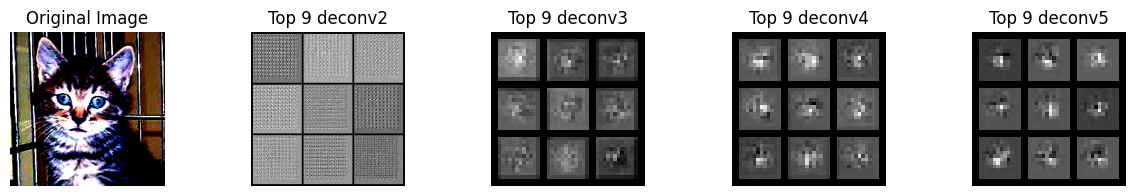

In [7]:
# Function to get top k activations and their positions
def get_top_activations(feature_map, num_activations=9):
    reshaped_map = feature_map.view(feature_map.size(0), -1)
    max_activations, max_indices = torch.max(reshaped_map, dim=1)
    top_activations, top_indices = torch.topk(max_activations, num_activations, dim=0)
    return top_activations, top_indices

# prepare for inference
model.eval()
model = model.to(device)

# Choose a few images from the validation set
num_images_to_visualize = 1
images_to_visualize, _ = next(iter(valid_loader)) # get a batch
images_to_visualize = images_to_visualize[:num_images_to_visualize]

# Move the input data to the same device as the model
images_to_visualize = images_to_visualize.to(device)

# Forward pass through the model
with torch.no_grad():
    outputs, intermediate_maps = model(images_to_visualize)

# Layers to visualize
layers = ['deconv2', 'deconv3', 'deconv4', 'deconv5']

# Loop through each image
for image_idx in range(num_images_to_visualize):
    plt.figure(figsize=(15, 2))

    # Plot the image
    original_image = images_to_visualize[image_idx].permute(1, 2, 0).cpu()
    plt.subplot(1, len(layers) + 1, 1)
    plt.imshow(original_image.numpy()) 
    plt.title("Original Image")
    plt.axis('off')

    # Visualize the top activations for each layer
    for idx, layer_name in enumerate(layers, start=1):
        feature_map = intermediate_maps[layer_name][image_idx].cpu()

        # Get top activations and their positions
        top_activations, top_indices = get_top_activations(feature_map)

        # Plot the top activations using make_grid
        top_activation_maps = torch.cat([feature_map[idx].unsqueeze(0) for idx in top_indices], dim=0)
        top_activation_grid = make_grid(top_activation_maps.unsqueeze(1), nrow=3, normalize=True).numpy().transpose(1, 2, 0)
        plt.subplot(1, len(layers) + 1, idx + 1)
        plt.imshow(top_activation_grid, cmap='viridis', vmin=0, vmax=1)  # Use 'viridis' colormap, you can experiment with others
        plt.title(f"Top 9 {layer_name}")
        plt.axis('off')

    plt.show()
#     plt.savefig(f"original_and_top_activations_image_{image_idx + 1}.png", dpi=300, bbox_inches='tight')
    plt.close()


## Part II activation maximization|

In [8]:
# we will use model2 is a copy of model with out deconv layers
class CustomActivConvNet(nn.Module):
    def __init__(self, num_classes=None, pretrained_weights=None):
        super(CustomActivConvNet, self).__init__()

        # Layer 1
        self.layer1conv = nn.Conv2d(3, 96, kernel_size=7, stride=2)
        self.layer1relu = nn.ReLU()
        self.layer1pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        self.layer1norm = nn.LocalResponseNorm(55)

        # Layer 2
        self.layer2conv = nn.Conv2d(96, 256, kernel_size=5, stride=2)
        self.layer2relu = nn.ReLU()
        self.layer2pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        self.layer2norm = nn.LocalResponseNorm(27)

        # Layer 3
        self.layer3conv = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.layer3relu = nn.ReLU()

        # Layer 4
        self.layer4conv = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.layer4relu = nn.ReLU()

        # Layer 5
        self.layer5conv = nn.Conv2d(384, 256, kernel_size=3)
        self.layer5relu = nn.ReLU()
        self.layer5pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        self.layer5norm = nn.LocalResponseNorm(13)

        # Fully connected layers
        self.fc1 = nn.Linear(4 * 4 * 256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        if pretrained_weights:
            self.load_pretrained_weights(pretrained_weights)

    def load_pretrained_weights(self, pretrained_weights):
        # Load weights from named modules of the original model
        for name, module in pretrained_weights.items():
            if name in self.state_dict():
                self.state_dict()[name].copy_(module)
          

    def forward(self, x):
        intermediate_feature_maps = {}

        # Layer 1
        x1conv = self.layer1conv(x)
        x1relu = self.layer1relu(x1conv)
        x1pool, x1poolind = self.layer1pool(x1relu)
        x1norm = self.layer1norm(x1pool)
        intermediate_feature_maps['x1conv'] = x1conv
        # print(f' layer 1 conv {x1conv.size()}, pool {x1pool.size()} norm {x1norm.size()}')

        # Layer 2
        x2conv = self.layer2conv(x1norm)
        x2relu = self.layer2relu(x2conv)
        x2pool, x2poolind = self.layer2pool(x2relu)
        x2norm = self.layer2norm(x2pool)
        intermediate_feature_maps['x2conv'] = x2conv
        # print(f'layer 2 conv {x2conv.size()}, pool {x2pool.size()} norm {x2norm.size()}')

        # Layer 3
        x3conv = self.layer3conv(x2norm)
        x3relu = self.layer3relu(x3conv)
        intermediate_feature_maps['x3conv'] = x3conv
        # print(f'layer 3 conv {x3conv.size()}')

        # Layer 4
        x4conv = self.layer4conv(x3relu)
        x4relu = self.layer4relu(x4conv)
        intermediate_feature_maps['x4conv'] = x4conv
        # print(f'layer 4 conv {x4conv.size()}')

        # Layer 5
        x5conv = self.layer5conv(x4relu)
        x5relu = self.layer5relu(x5conv)
        x5pool, x5poolind = self.layer5pool(x5relu)
        x5norm = self.layer5norm(x5pool)
        intermediate_feature_maps['x5conv'] = x5conv
        # print(f'layer 5 conv {x5conv.size()}, pool {x5pool.size()} norm {x5norm.size()}')

        
        # Flatten the output for fully connected layers
        x_flatten = x5norm.view(x5norm.size(0), -1)
        x_flatten = x_flatten.view(-1)
        # print("flatten_size", x_flatten.size())
        # Fully connected layers
        x = self.fc1(x_flatten)
        x = self.fc2(x)
        x = self.fc3(x)

        return x, intermediate_feature_maps

    
# load trained model
original_model = CustomDeConvNet(num_classes=len(class_names))
original_model.load_state_dict(torch.load('/kaggle/input/final-model/class_model.pth',map_location=torch.device('cpu')))

# Create an instance of the model2 using orginal model weights
model2 = CustomActivConvNet(num_classes=len(class_names), pretrained_weights=original_model.state_dict())
# Send the model to the device
model2 = model2.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # applied sofmax internally
optimizer = optim.Adam(model2.parameters(), lr=0.0001)


In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# undo the above normalization if and when the need arises 
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                   std = [1/0.229, 1/0.224, 1/0.225] )

In [10]:
# create random image, move to device and set grad and optim
def random_image(Height = 224, Width = 224, device = 'cpu', requires_grad=False, optimizer=None, lr = 0.01):
    img = np.single(np.random.uniform(0,1, (3, Height, Width))) # we need the pixel values to be of type float32
    im_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(requires_grad) # normalize the image to have requisite mean and std. dev.
    print("img_shape:{}, img_dtype: {}".format(im_tensor.shape, im_tensor.dtype ))
    if optimizer:
        if requires_grad:
            return im_tensor, optimizer([im_tensor], lr = lr)
        else: 
            print('Error: Optimizer cannot be used on an image without setting its requires_grad_  ')
    return im_tensor

In [11]:
# denormalize and prepare image for plot
def image_converter(im):
    # move the image to cpu
    im_copy = im.cpu()
    # for plt.imshow() the channel-dimension is the last
    # therefore use transpose to permute axes
    im_copy = denormalize(im_copy.clone().detach()).numpy().transpose(1,2,0)
    # clip negative values as plt.imshow() only accepts 
    # floating values in range [0,1] and integers in range [0,255]
    im_copy = im_copy.clip(0, 1) 
    return im_copy

img_shape:torch.Size([3, 224, 224]), img_dtype: torch.float32


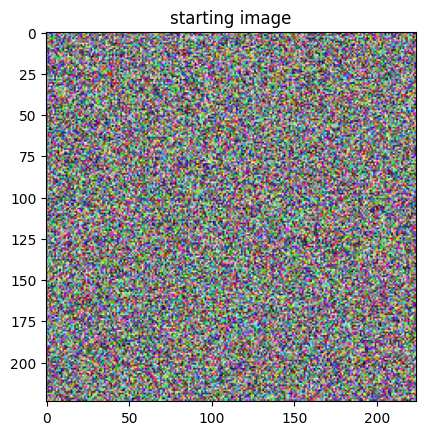

In [12]:
# generating the initial image with random pixel values between 0 and 1
H = 224 # height of input image
W = 224 # width of input image
img_tensor, optimizer = random_image(Height = H, Width = W, device = device, 
                                     requires_grad = True, optimizer = optim.Adam, lr = 0.01)

# Starting Image
plt.imshow(image_converter(img_tensor))                                                               
plt.title('starting image')
plt.show()

In [13]:
# create hooks on model layers to acces outputs after forward pass
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook
activation = {}
for name, module in model2.named_modules():
    activation[name] = module.register_forward_hook(layer_hook(activation, name))

In [14]:
activation

{'': <torch.utils.hooks.RemovableHandle at 0x7a0168321720>,
 'layer1conv': <torch.utils.hooks.RemovableHandle at 0x7a0160407280>,
 'layer1relu': <torch.utils.hooks.RemovableHandle at 0x7a0160405ea0>,
 'layer1pool': <torch.utils.hooks.RemovableHandle at 0x7a0160407bb0>,
 'layer1norm': <torch.utils.hooks.RemovableHandle at 0x7a0160407940>,
 'layer2conv': <torch.utils.hooks.RemovableHandle at 0x7a0160406e90>,
 'layer2relu': <torch.utils.hooks.RemovableHandle at 0x7a0160407a60>,
 'layer2pool': <torch.utils.hooks.RemovableHandle at 0x7a0160407250>,
 'layer2norm': <torch.utils.hooks.RemovableHandle at 0x7a0160407f10>,
 'layer3conv': <torch.utils.hooks.RemovableHandle at 0x7a0160404af0>,
 'layer3relu': <torch.utils.hooks.RemovableHandle at 0x7a01604072e0>,
 'layer4conv': <torch.utils.hooks.RemovableHandle at 0x7a016057baf0>,
 'layer4relu': <torch.utils.hooks.RemovableHandle at 0x7a01602a72b0>,
 'layer5conv': <torch.utils.hooks.RemovableHandle at 0x7a01602a7130>,
 'layer5relu': <torch.utils.ho

In [15]:
# running some gradient ascent steps to maximize activations 
model2.eval()

num_epochs = 900
display_every = 100


layer_names = ['layer1conv', 'layer2conv', 'layer3conv', 'layer4conv', 'layer5conv']
unit_idx_range = (1, 90)

# Initialize the model, optimizer, img_tensor, and activation
# Assuming these are defined before the loop

all_images = []  # images to visualize

for layer_name in layer_names:
    layer_images = []  # images to visualize
    img_tensor, optimizer = random_image(Height = H, Width = W, device = device, 
                                     requires_grad = True, optimizer = optim.Adam, lr = 0.01)
     # Randomly choose a unit_idx
    unit_idx = random.randint(unit_idx_range[0], unit_idx_range[1])
    unit_idx = 0
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Forward pass
        model2(img_tensor.unsqueeze(0))
        
        # Get the output of the target layer
        layer_out = activation[layer_name]
        
        # Calculate the loss for the specified unit for gradient ascent
        loss = layer_out[0, unit_idx].mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Display the images at regular intervals
        if epoch % display_every == 0:
            print('Epoch: {}/{}, Layer: {}, Unit Index: {}, Activation: {:.4f}'.format(epoch, num_epochs, layer_name, unit_idx, loss.item()))

            # Append the image to the list
            layer_images.append(image_converter(img_tensor))
    all_images.append(layer_images)

img_shape:torch.Size([3, 224, 224]), img_dtype: torch.float32
Epoch: 0/900, Layer: layer1conv, Unit Index: 0, Activation: -0.0130
Epoch: 100/900, Layer: layer1conv, Unit Index: 0, Activation: -1.6469
Epoch: 200/900, Layer: layer1conv, Unit Index: 0, Activation: -3.2808
Epoch: 300/900, Layer: layer1conv, Unit Index: 0, Activation: -4.9147
Epoch: 400/900, Layer: layer1conv, Unit Index: 0, Activation: -6.5487
Epoch: 500/900, Layer: layer1conv, Unit Index: 0, Activation: -8.1826
Epoch: 600/900, Layer: layer1conv, Unit Index: 0, Activation: -9.8165
Epoch: 700/900, Layer: layer1conv, Unit Index: 0, Activation: -11.4504
Epoch: 800/900, Layer: layer1conv, Unit Index: 0, Activation: -13.0843
img_shape:torch.Size([3, 224, 224]), img_dtype: torch.float32
Epoch: 0/900, Layer: layer2conv, Unit Index: 0, Activation: -4.9130
Epoch: 100/900, Layer: layer2conv, Unit Index: 0, Activation: -11.0343
Epoch: 200/900, Layer: layer2conv, Unit Index: 0, Activation: -17.6937
Epoch: 300/900, Layer: layer2conv, U

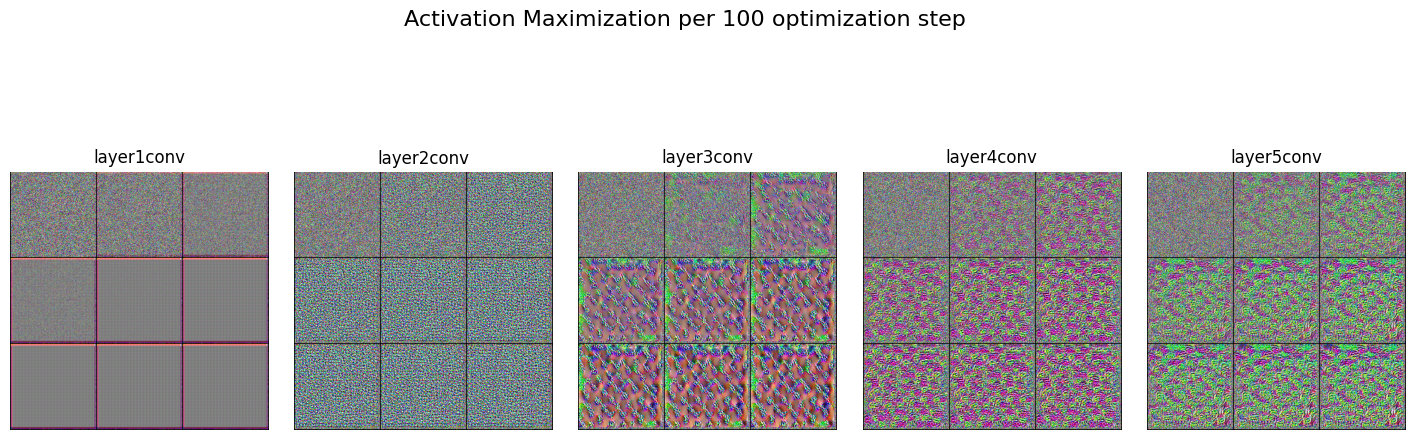

In [16]:
# plot in grid shape
layer_names = ['layer1conv', 'layer2conv', 'layer3conv', 'layer4conv', 'layer5conv']
fig, axs = plt.subplots(1, len(layer_names), figsize=(18, 6))  # Increase figsize
grids = []

for i, (sublist, layer_name) in enumerate(zip(all_images, layer_names)):
    normalized_tensors = [transforms.ToTensor()(img) for img in sublist]

    # Create a grid from the tensors in the sublist
    grid = make_grid(normalized_tensors, nrow=3)
    
    # Append the grid to the list of final grids
    grids.append(grid)

    # Display the grid on the corresponding subplot
    axs[i].imshow(grid.permute(1, 2, 0).cpu())  # Transpose the dimensions for matplotlib
    axs[i].axis('off')
    axs[i].set_title(layer_name)

fig.suptitle('Activation Maximization per 100 optimization step', fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1)  # Reduce the spacing between subplots
# Show the plot
plt.show()


### we can see that naeive activation maximization doesnt produce undestandable patters we will test another method with gausian blurying below

In [17]:
!git clone 'https://github.com/farhad-dalirani/PytorchRevelio.git'
import sys
sys.path.append('/kaggle/working/PytorchRevelio')

Cloning into 'PytorchRevelio'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 291 (delta 12), reused 0 (delta 0), pack-reused 268
Receiving objects: 100% (291/291), 10.83 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [18]:
from PytorchRevelio import PytorchRevelio

# Constants
IMG_SIZE_ORIGINAL = (224, 224, 3)

# Assuming img_transformer is your image transformation function and device is your desired device
img_transformer = transforms.Compose([transforms.Resize(IMG_SIZE_ORIGINAL[:2]), transforms.ToTensor()])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

layer_index = 1
# Create a list to store images for each layer
layer_images_list = []

for layer_name, layer in model2.named_modules():
    
    # Select convolutional and layers for visualization
#     if isinstance(layer, (nn.Conv2d, nn.Linear)):
    if isinstance(layer, (nn.Conv2d)):
        filter_neuron_num = layer.out_channels if isinstance(layer, nn.Conv2d) else layer.out_features
        layer_type = 'Conv2d' if isinstance(layer, nn.Conv2d) else 'Linear'
        num_iter = 450
        lr = 0.09
        start_sigma = 2.5 if isinstance(layer, nn.Conv2d) else 7.5
        end_sigma = 0.5 if isinstance(layer, nn.Conv2d) else 2.5
    else:
        continue
    
    # From each layer, select 9 filter or neuron indices
    filters_neuron_indices = np.random.choice(range(filter_neuron_num), size=9, replace=True)

    # Create a list to store activations for the current layer
    current_layer_images = []
    if 'fc' in layer_name:
        continue
    for i, filter_neuron_index in enumerate(filters_neuron_indices):
        print('Processing of layer {}, filter/neuron {} is done.'.format(layer_name, filter_neuron_index))

        img = PytorchRevelio.activation_maximization_with_gaussian_blurring(
            network=model2,
            img_transformer=img_transformer,
            in_img_size=IMG_SIZE_ORIGINAL,
            first_layer_name='layer1conv',
            layer_name=layer_name,
            filter_or_neuron_index=filter_neuron_index,
            num_iter=num_iter,
            start_sigma=start_sigma,
            end_sigma=end_sigma,
            lr=lr,
            device=device
        )
        current_layer_images.append(img) # combine the n activations
        
    layer_images_list.append(current_layer_images) # combine all layers
    layer_index += 1

Processing of layer layer1conv, filter/neuron 7 is done.


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing of layer layer1conv, filter/neuron 57 is done.
Processing of layer layer1conv, filter/neuron 5 is done.
Processing of layer layer1conv, filter/neuron 29 is done.
Processing of layer layer1conv, filter/neuron 26 is done.
Processing of layer layer1conv, filter/neuron 55 is done.
Processing of layer layer1conv, filter/neuron 67 is done.
Processing of layer layer1conv, filter/neuron 82 is done.
Processing of layer layer1conv, filter/neuron 80 is done.
Processing of layer layer2conv, filter/neuron 49 is done.
Processing of layer layer2conv, filter/neuron 22 is done.
Processing of layer layer2conv, filter/neuron 102 is done.
Processing of layer layer2conv, filter/neuron 161 is done.
Processing of layer layer2conv, filter/neuron 190 is done.
Processing of layer layer2conv, filter/neuron 192 is done.
Processing of layer layer2conv, filter/neuron 202 is done.
Processing of layer layer2conv, filter/neuron 152 is done.
Processing of layer layer2conv, filter/neuron 102 is done.
Processi

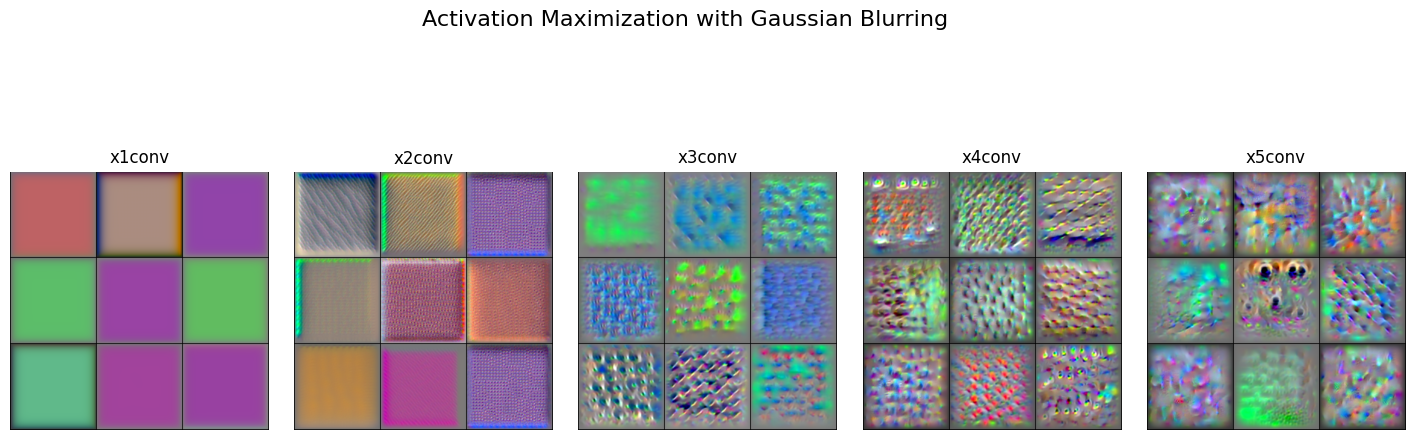

In [19]:
# plot in grid shape
layer_names = ['x1conv', 'x2conv', 'x3conv', 'x4conv', 'x5conv']
fig, axs = plt.subplots(1, len(layer_images_list), figsize=(18, 6)) 
grids = []

for i, (sublist, layer_name) in enumerate(zip(layer_images_list, layer_names)):

    normalized_tensors = [transforms.ToTensor()(PytorchRevelio.tensor_outputs_to_image(tensor)) for tensor in sublist]

    # Create a grid from the tensors in the sublist
    grid = make_grid(normalized_tensors, nrow=3)

    # Append the grid to the list of final grids
    grids.append(grid)

    # Display the grid on the corresponding subplot
    axs[i].imshow(grid.permute(1, 2, 0).cpu())  # Transpose the dimensions for matplotlib
    axs[i].axis('off')
    axs[i].set_title(layer_name)

fig.suptitle('Activation Maximization with Gaussian Blurring', fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1)  # Reduce the spacing between subplots
# Show the plot
plt.show()
